
# CIFAR-10 이미지 생성하기


# STEP 1. 작업환경 구성하기

In [1]:
import tensorflow as tf
import imageio
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.2


# STEP 2. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.


170508288/170498071 [==============================] - 11s 0us/step


In [3]:
print(train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

(50000, 32, 32, 3)
max pixel: 1.0
min pixel: -1.0


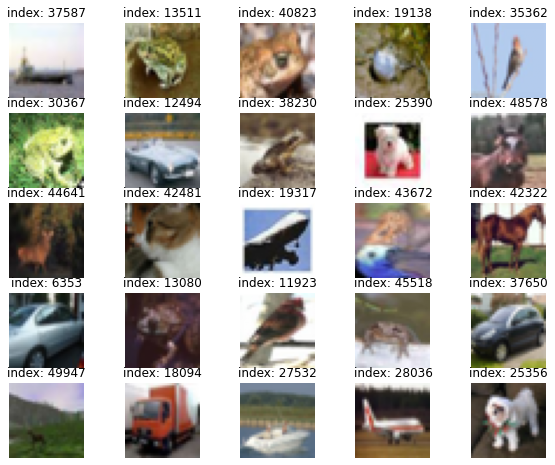

In [4]:
plt.figure(figsize=(10,8))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

# STEP 3. 생성자 모델 구현하기

In [5]:


def make_generator_model():
    model = tf.keras.Sequential()
    
    #첫번째: Dense Layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #두번째: Reshape Layer
    model.add(layers.Reshape((8,8, 256)))

    #세번째: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #네번째: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #다섯번째: Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [6]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

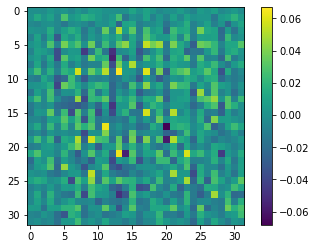

In [7]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# STEP 4. 판별자 모델 구현하기

In [8]:
# (32, 32, 3)의 이미지를 입력으로 받아 1dim 판별결과를 출력하는 판별자 모델 구현 함수를 작성
# STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인
# 입력은 (32,32,3) 크기의 이미지가, 출력은 얼마나 진짜와 같은지 판단하는 실수값


def make_discriminator_model():
    model = tf.keras.Sequential()
    #첫번째: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5),  strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #두번째: Convs2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #세번째: Flatten Layer
    model.add(layers.Flatten())

    #네번째: Dense Layer
    model.add(layers.Dense(1))

    return model



discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [9]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00520961]], dtype=float32)>

# STEP 5. 손실함수와 최적화 함수 구현하기

In [10]:

# 생성자와 판별자의 손실함수(loss)를 구현.
# 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
# 생성자와 판별자를 최적화하는 optimizer를 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss    

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)   

In [11]:
BUFFER_SIZE = 50000
#BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정합니다. 
#shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


#STEP 6. 훈련과정 상세 기능 구현하기

In [12]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [13]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [14]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex11/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [15]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/ex11/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [16]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/ex11/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

# STEP 7. 학습 과정 진행하기

In [18]:
save_every = 5
EPOCHS = 100

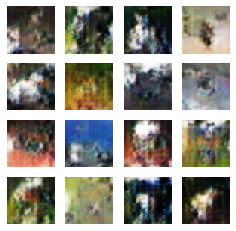

Time for training : 1466 sec


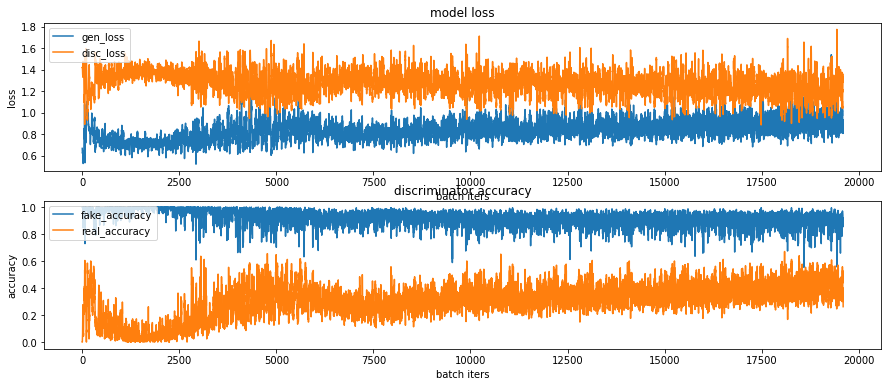

CPU times: user 17min 38s, sys: 38.8 s, total: 18min 17s
Wall time: 24min 28s


In [19]:
%%time
train(train_dataset, EPOCHS, save_every)

#step 8. 훈련과정 개선하기

In [20]:
# 개선모델

def make_generator_model_ver2():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*128, use_bias=False,activation= 'relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))

    model.add(layers.Reshape((8,8, 128)))

    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))

    model.add(layers.Conv2DTranspose(128, kernel_size= 4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))      
    model.add(layers.LeakyReLU(alpha = 0.1))
    

    model.add(layers.Conv2D(128, kernel_size= 5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))      
    model.add(layers.LeakyReLU(alpha = 0.1))


    model.add(layers.Conv2DTranspose(128, kernel_size= 4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))      
    model.add(layers.LeakyReLU(alpha = 0.1))

    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))      
    model.add(layers.LeakyReLU(alpha = 0.1))    
    
    model.add(layers.Conv2D(3, kernel_size = 5, strides = 1, padding = 'same', activation='tanh'))

    return model

In [21]:
generator_ver2 = make_generator_model_ver2()
generator_ver2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_3 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262144    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                      

In [22]:
noise = tf.random.normal([1,100])
generated_image = generator_ver2(noise, training = False)
generated_image.shape

TensorShape([1, 32, 32, 3])

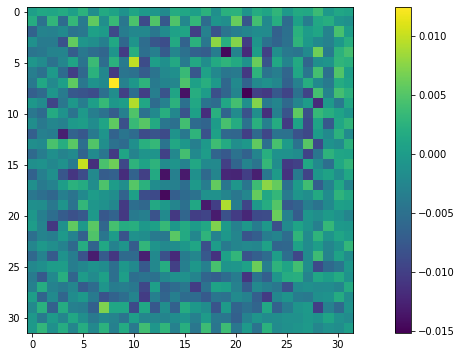

In [23]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [24]:
# Discriminator model ver.2

def make_discriminator_model_ver2():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

   
    model.add(layers.Conv2D(64, kernel_size = 3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size = 3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size = 3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))    

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [25]:
discriminator_ver2 = make_discriminator_model_ver2()
discriminator_ver2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                      

In [26]:
save_every = 5
EPOCHS = 1000

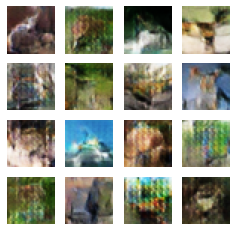

Time for training : 4185 sec


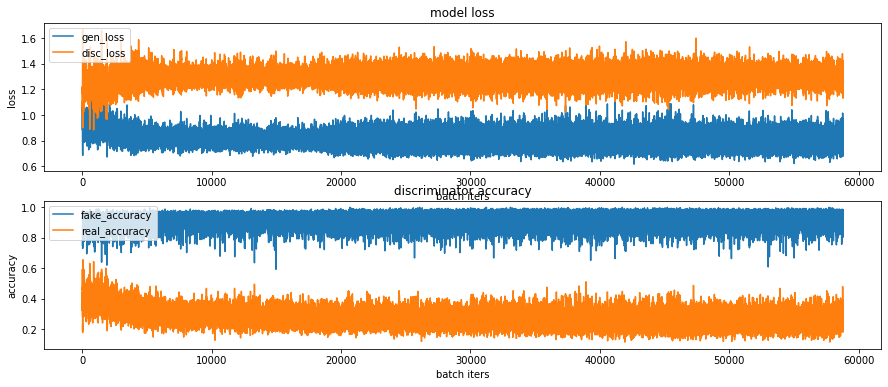

CPU times: user 57min 12s, sys: 1min 51s, total: 59min 4s
Wall time: 1h 9min 49s


In [27]:
%%time
train(train_dataset, EPOCHS, save_every)

## 회고
fake_accuracy가 0.5를 향해 내려가게 하기 위해 각 레이어의 커널 사이즈, 스트라이드와 Adam 옵티마이저의 숫자를 조정해 가면서 두가지 모델을 만들어 훈련을 시켰지만 개선된 모델에서도 fake_accuracy 값은 큰 변화 없이 여전히 1에 가까이 머물고 있다. 만족할만한 결과를 위해 하이퍼 파라미터 조정하는 방법은 어려운 연구와 경험이 필요한 것 같다.  